### Importações necessárias:

In [170]:
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import Sequential
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix, recall_score

In [1]:
# Diretórios
train_dir = 'training_set/training_set'
test_dir = 'test_set/test_set'

images = []
labels = []

### Verificação do funcionamento:

In [172]:
print(os.listdir(train_dir))
print(os.listdir(test_dir))

['cats', 'dogs']
['cats', 'dogs']


In [173]:
# Mapeia os labels para inteiros
unique_labels = sorted(os.listdir(train_dir))
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

for folder_name in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder_name)

    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            image = cv2.imread(file_path)

            if image is not None and image.size != 0: # Verifica se a imagem foi lida corretamente
                resized_image = cv2.resize(image, (256, 256))
                images.append(resized_image)
                # Converte o label string para um inteiro usando o mapeamento
                labels.append(label_to_int[folder_name])

print("Exemplo de labels convertidos:", labels[:10])


Exemplo de labels convertidos: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


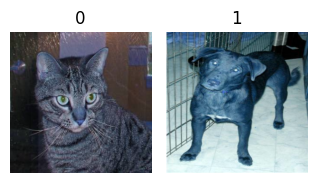

In [174]:
# Plot de imagens de exemplo
unique_labels = list(set(labels))
num_labels = len(unique_labels)
num_labels_per_line = 4
labels_array = np.array(labels)

for i, label in enumerate(unique_labels):
    index = labels_array.tolist().index(label)
    image = images[index]
    plt.subplot(num_labels // num_labels_per_line + 1, num_labels_per_line, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Divisão do dataset entre train e test:

In [150]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    )

test  = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=False,
    )

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


### Processo de normalização das imagens:

In [151]:
def processamento(image,label):
    image = tf.cast(image/255 , tf.float32)
    return image , label

train = train.map(processamento)
test  = test.map(processamento)

### Modelo MobileNetV2 foi utilizado:

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Saída única para classificação binária
])

In [153]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_34 (Dense)            (None, 128)               163968    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,422,081
Trainable params: 164,097
Non

In [154]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Adição de Checkpoints e EarlyStopping:

In [155]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    filepath = 'model.keras',
    monitor ='val_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
    )

### Fitting do modelo:

In [156]:
history = model.fit(train, batch_size = 32, epochs=20, validation_data=test, callbacks=[checkpoint, early_stopping])

Epoch 1/20


250/251 [============================>.] - ETA: 0s - loss: 0.0636 - accuracy: 0.9770
Epoch 1: val_accuracy improved from -inf to 0.98913, saving model to model.keras
251/251 [==============================] - 21s 73ms/step - loss: 0.0636 - accuracy: 0.9770 - val_loss: 0.0449 - val_accuracy: 0.9891
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9875
Epoch 2: val_accuracy did not improve from 0.98913
251/251 [==============================] - 17s 66ms/step - loss: 0.0348 - accuracy: 0.9875 - val_loss: 0.0425 - val_accuracy: 0.9886
Epoch 3/20
250/251 [============================>.] - ETA: 0s - loss: 0.0280 - accuracy: 0.9894
Epoch 3: val_accuracy did not improve from 0.98913
251/251 [==============================] - 16s 65ms/step - loss: 0.0280 - accuracy: 0.9894 - val_loss: 0.0658 - val_accuracy: 0.9807
Epoch 4/20
250/251 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9929
Epoch 4: val_accuracy did not improve from 0.

### Resultado:

In [160]:
best_model_accuracy = max(history.history['accuracy'])
best_model_val_accuracy = max(history.history['val_accuracy'])

print(f'Training Accuracy: {(best_model_accuracy * 100):.2f}%')
print(f'Validation Accuracy: {(best_model_val_accuracy * 100):.2f}%')

Training Accuracy: 99.45%
Validation Accuracy: 98.91%


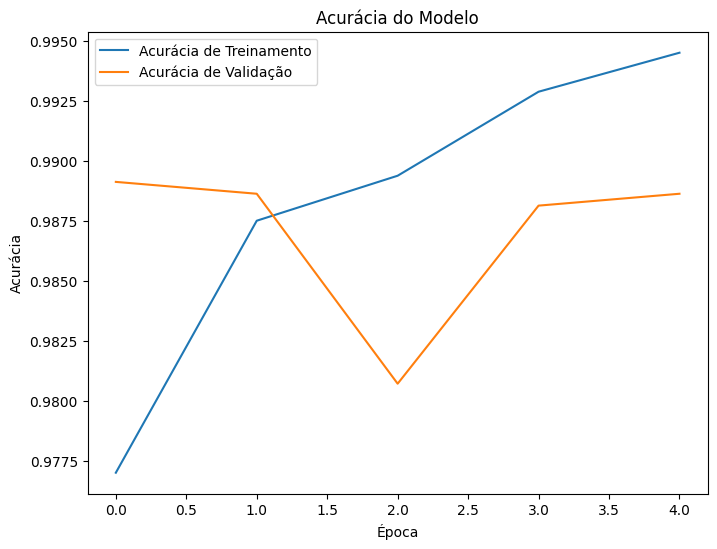

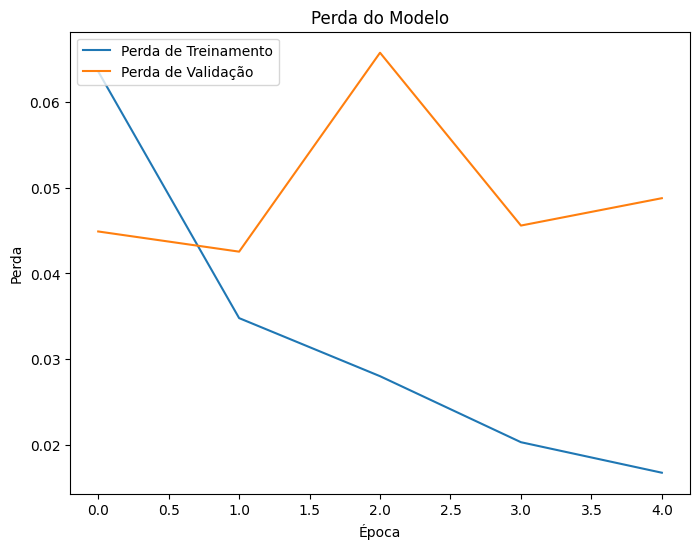

In [161]:
# Plot de Acurácia
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(loc='upper left')
plt.show()

# Plot de Perda
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(loc='upper left')
plt.show()

64/64 [==============================] - 3s 54ms/step
Matriz de Confusão:
[[ 998   13]
 [  10 1002]]


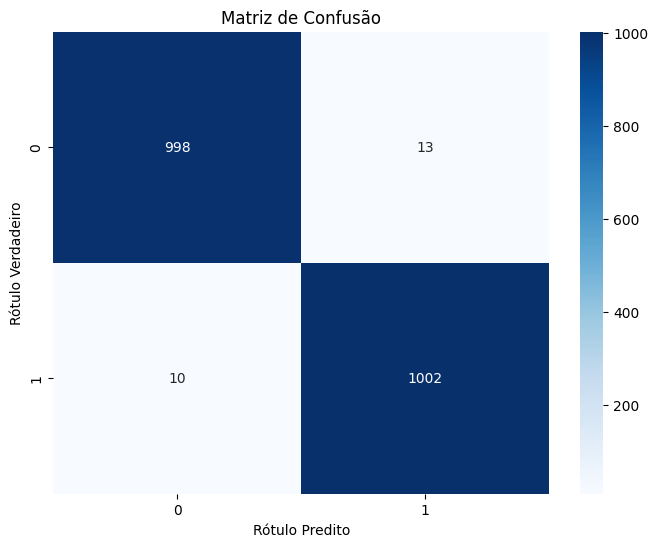

Recall: 0.9901185770750988


In [ ]:
y_pred = model.predict(test)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test], axis=0).flatten()

cm = confusion_matrix(y_true, y_pred_labels)
print("Matriz de Confusão:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

recall = recall_score(y_true, y_pred_labels, average='binary')
print("Recall:", recall)

### Teste Real:

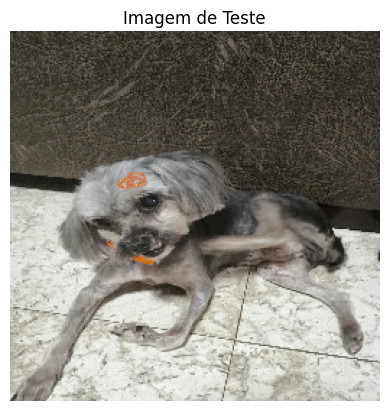

1/1 [==============================] - 1s 530ms/step
Probabilidade: 1.0000
Rótulo previsto: Dog


In [ ]:
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Não foi possível carregar a imagem. Verifique o caminho:", image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image.astype('float32') / 255.0

    return image

image = 'image.jpg'

img = load_and_preprocess_image(image)

# Exibe a imagem
plt.imshow(img)
plt.title("Imagem de Teste")
plt.axis("off")
plt.show()

# Expande a dimensão da imagem para incluir o batch dimension (ficar shape: (1, 256, 256, 3))
img_expanded = np.expand_dims(img, axis=0)

pred_prob = model.predict(img_expanded)
print(f'Probabilidade: {pred_prob[0][0]:.4f}')

if pred_prob[0][0] >= 0.5:
    print("Rótulo previsto: Cachorro")
else:
    print("Rótulo previsto: Gato")